In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputs_wTraces,print_df
from metrics import get_R2

fig_folder = '/Users/kendranoneman/Figures/neural-decoding'

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0),(0.3,0.0,0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]

In [2]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs'

data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

sess_size = len(out_times)

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+'/',["-o0-","s29"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+'/',["-o1-","s29"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+'/',["-o2-","s29"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==7)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()
print(best_fold)
df.head(1)

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']

df['train_time'] = df['train_time'] / 60

3


# Figure 1a: How do the decoding models work?

In [ ]:
from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.15)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.15)].index
    
##############################################################################################
trial = [1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='mediumpurple', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='forestgreen', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(10, 5.5))
fig2a.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='-', linewidth=10)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='--', linewidth=10)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig2a.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight');

# Figure 1b: How well do the decoding models perform?

[0.6464173115049706, 0.6475077537059405, 0.709309950801212, 0.762344481664259, 0.8610253083980075, 0.8447358994330086, 0.8798921101940858, 0.874873389668904]


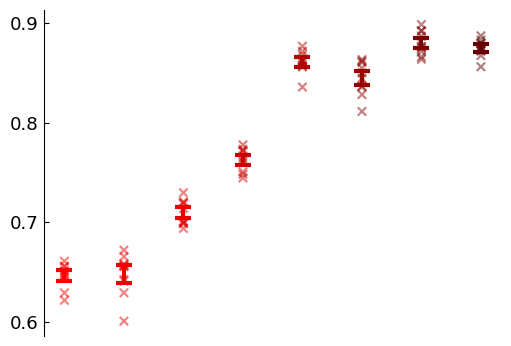

In [53]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1, figsize=(5.5, 4), sharey=True)
fig.tight_layout()

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]

pal = [reds,oranges,pinks]

sess = 29
values = ['R2_mn']
b = 50
dsf = 1
o = 'position'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
print(means)
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting

for pos, y, yerr, color in zip(ind, means, err, reds): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm

    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(reds[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
    ax.set_yticks([0.6,0.7,0.8,0.9])

#ax.set_ylim(0.58,0.92);
#fig.savefig(fig_folder+'/mnR2_8models.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.5), sharey=True)
fig.tight_layout()

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]
grays = [(0.95,0.75,0.75),(0.9,0.7,0.7),(0.85,0.65,0.65),(0.8,0.6,0.6),(0.75,0.55,0.55),(0.7,0.5,0.5),(0.65,0.45,0.45),(0.6,0.4,0.4)]

print(len(reds))
print(len(grays))
pal = [reds,oranges,pinks]

sess = 29
values = ['R2sh_mn']
b = 50
dsf = 1
o = 'position'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==dsf)]).groupby('outer_fold')[values].mean().values

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm

    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
#ax.set_yticks([-1,-0.3])

#ax.set_ylim(-1.1,-0.25);
fig.savefig(fig_folder+'/nullR2_8models.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(2,1,figsize=(9,5.5))#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all0
y_test_predicted = yTestPred_all0

mdls = df0[(df0['outer_fold'] == best_fold) & (df0['downsample_factor'] == 1) & (df0['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 4
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)

Nts = 5
plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.5, linewidth=3.5, linestyle='dashed', label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-11.5,16)
axes[0].set_xticks([])
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=5.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-14.5,12)
axes[1].set_yticks([-10,0,10])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.01)
fig.savefig(fig_folder+'/traces_8models.png', dpi=600, bbox_inches='tight')


In [ ]:
plt.rcParams.update({'font.size': 12})

df = df2[['nMT','nFEF','mean_R2','sess','repeat','outer_fold']]
df = df.loc[df2['sess']==29]

conditions = [
    (df['nFEF'] == 0),
    (df['nMT'] == 0),
    (df['nMT'] == df['nFEF']),
    (df['nMT'] > 0) & (df['nFEF'] > 0) & (df['nMT'] != df['nFEF'])
    ]

values = ['mt only', 'fef only', 'mt=fef','mt+fef']
df['condition'] = np.select(conditions, values)
df['num_neurons'] = df.loc[:,['nMT','nFEF']].sum(axis=1)
df = df.loc[(df['num_neurons']<=np.array([df['nMT'].max(),df['nFEF'].max()]).max())]

df_mn = df.groupby(['nFEF', 'nMT', 'num_neurons'])["mean_R2"].mean().reset_index(name="mR2")
df_sd = df.groupby(['nFEF', 'nMT', 'num_neurons'])["mean_R2"].std().reset_index(name="sR2")

fef_mn = df_mn.loc[df_mn['nMT']==0]['mR2'].values
fef_sd = (df_sd.loc[df_sd['nMT']==0]['sR2'].values)*np.sqrt(1./10+1./(10-1))
mt_mn = df_mn.loc[df_mn['nFEF']==0]['mR2'].values
mt_sd = (df_sd.loc[df_sd['nFEF']==0]['sR2'].values)*np.sqrt(1./10+1./(10-1))
mf_mn = df_mn.loc[df_mn['nFEF']==df_mn['nMT']]['mR2'].values
mf_sd = (df_sd.loc[df_sd['nFEF']==df_mn['nMT']]['sR2'].values)*np.sqrt(1./10+1./(10-1))

fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.errorbar(np.arange(2,2+(len(fef_mn)*2),2), fef_mn, fef_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color='mediumpurple', zorder=2)
ax.errorbar(np.arange(2,2+(len(mt_mn)*2),2), mt_mn, mt_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color='mediumseagreen',zorder=3)
ax.errorbar(np.arange(4,4+(len(mf_mn)*4),4), mf_mn, mf_sd, lw=3, capsize=4, marker='o', alpha=0.8, markersize=7, capthick=2,  color='cornflowerblue',zorder=1)

ax.set_xticks(np.arange(0,41,4))
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
#ax.set_ylim(0.01,0.678)

#fig.savefig(fig_folder+'/r2_numNeurons-onesess.png', dpi=600, bbox_inches='tight') 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with a linear fit
sns.set(style="white")
plt.figure(figsize=(8, 6))

# Plot the scatter plot
#sns.scatterplot(data=df0, x='output_binWidth', y='preProcess_time')
#sns.scatterplot(data=df0, x='output_binWidth', y='train_time')
sns.scatterplot(data=df0, x='output_binWidth', y='test_time')

# Add the linear regression line
#sns.regplot(data=df0, x='output_binWidth', y='train_time', ci=None)

# Set plot labels and title
plt.xlabel('output bin width')
plt.ylabel('train time (s)')
#plt.title('Scatter Plot with Linear Fit')

# Show the plot
plt.show()



In [ ]:
# Find the index where conditions are met
index = df[(df['model'] == 4) & (df['downsample_factor'] == 1) & (df['output_binWidth'] == 50)].index
print(index)
print(yTest_all0[430].shape)

R2 = get_R2(yTest_all0[430],yTestPred_all0[430])
print(R2)
#yTest_all0, yTestPred_all0

In [ ]:
plt.rcParams.update({'font.size': 13})

# List of unique bin_size values
unique_bin_sizes = sorted(df['binsPre'].unique())
print(unique_bin_sizes)

# Create subplots for each bin_size
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
fig.tight_layout()

#fig, ax = plt.subplots(1,1,figsize=(6,6))
#fig.tight_layout()

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]

pal = [reds,oranges,pinks]

sess = 29
values = ['R2_mn']
outputs = ['position'] #,'velocity','acceleration'
bin_size = [25,50,75,100,125,150]

#for o in range(len(outputs)):
for i, ax in enumerate(axs.flat):
    b = unique_bin_sizes[i]
    ax.set_title(f'binsPre = {b}')  # Set subplot title
    o = 0
    wf   = (df.loc[(df['model']==0) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    wc   = (df.loc[(df['model']==1) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    xgb   = (df.loc[(df['model']==3) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    svr   = (df.loc[(df['model']==4) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    dnn  = (df.loc[(df['model']==5) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    rnn  = (df.loc[(df['model']==6) & (df['sess']==sess) & (df['binsPre']==b) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    #gru  = (df.loc[(df['model']==7) & (df['sess']==sess) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values
    #lstm = (df.loc[(df['model']==8) & (df['sess']==sess) & (df['output']==outputs[o])]).groupby('outer_fold')[values].mean().values

    n=10
    means=([np.mean(wf),np.mean(wc),np.mean(kf),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn)])#,np.mean(gru),np.mean(lstm)])
    err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(kf)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1))])#,np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])
    
    ind = np.arange(len(err)) #X values for plotting

    for pos, y, yerr, color in zip(ind, means, err, pal[o]): #Loop through methods and plot error bars
        ax.errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color, zorder=0)

        ax.set_xticks(np.arange(len(means)))
        ax.set_xticklabels(['wf','wc','kf','xgb','svr','dnn','rnn'], rotation=0) #,'gru','lstm'
        ax.tick_params(direction='in',bottom=0)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
        scatter_y=np.concatenate((wf,wc,kf,xgb,svr,dnn,rnn),axis=0) #,gru,lstm
        
        colors_list=[] 
        for j in scatter_x.astype(int).reshape((1,-1))[0]:
            colors_list.append(pal[o][j])

        ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
        #ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
                 
#fig.savefig(fig_folder+'/R2_posVelAcc.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(3,1,figsize=(9,6),sharex=True)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df

mdls = np.arange(best_fold, 80+(best_fold),10)
jmdls =[0,1,4,5,6,7]
mdls = mdls[jmdls]


with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[best_fold]['model'],DF.loc[best_fold]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)
    
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 4
    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all) 
trl_names = np.array(trl_names)

Nts = 10
plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]
#print(bad_trls)
#print(plot_trls)

#plot_trls = bad_trls

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000

axes[0].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[0].plot(x,y_test_predicted[i][start_end,1], color=pal[0][j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[0].plot(x,y_test_predicted[i][start_end,1], color=pal[0][j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-12,14.5)
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')

y_test = yTest_all1
y_test_predicted = yTestPred_all1

axes[1].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[1][j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[1][j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

axes[1].set_ylim(-35,25)
axes[1].set_yticks([-20,0,20])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

y_test = yTest_all2
y_test_predicted = yTestPred_all2

axes[2].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[2].plot(x,y_test_predicted[i][start_end,1], color=pal[2][j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[2].plot(x,y_test_predicted[i][start_end,1], color=pal[2][j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

axes[2].set_ylim(-150,250)
#axes[1].set_yticks([-10,0,10])
axes[2].spines['right'].set_color('none')
axes[2].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.3, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_PosVelAcc.png', dpi=600, bbox_inches='tight') 

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(8,1,figsize=(9,15),sharex=True,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mi = DF['R2_mn'].idxmax()

mdls = np.arange(mi%10, 80+(mi%10),10)
jmdls = range(len(mdls))

lstyles = ['dotted','dotted','dotted','dotted','dotted','dashed','dashed','dashed']
if len(jmdls) < 3:
    lw = 1.5
else:
    lw = 1

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28]) #3,6,24,27,28
print(trl_nums[plot_trls])

start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

axes[0].plot(x,y_test[mi][start_end,0], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[0].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[0].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)


axes[0].set_xlim(x[0],x[-1]-0.95)
axes[0].set_ylim(-13,14.5)
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False)
axes[0].spines['bottom'].set_visible(False)


axes[1].plot(x,y_test[mi][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    axes[1].text(6.5, 23-(j*2.4), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    #axes[1].text(6.3, -9-(j*0.4), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    
    #axes[0].text(7.1, (-10)-(j*1.0), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    
axes[1].set_ylim(-15.5,12.5)
axes[1].set_yticks([-10,0,10])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

for o in range(2):
    if o==0:
        y_test = yTest_all1
        y_test_predicted = yTestPred_all1
        DF = df1
        oo = [3,4]
    else:
        y_test = yTest_all2
        y_test_predicted = yTestPred_all2
        DF = df2
        oo = [6,7]
        
    axes[oo[0]].plot(x,y_test[mi][start_end,0], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)', zorder=0)
    for i,j in zip(mdls,jmdls):
        axes[oo[0]].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
        axes[oo[0]].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

    axes[oo[0]].set_xlim(x[0],x[-1]-0.95)
    axes[oo[0]].spines['right'].set_color('none')
    axes[oo[0]].spines['top'].set_color('none')
    axes[oo[0]].tick_params(axis='x', which='both', bottom=False, top=False)
    axes[oo[0]].spines['bottom'].set_visible(False)

    axes[oo[1]].plot(x,y_test[mi][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)', zorder=0)
    for i,j in zip(mdls,jmdls):
        axes[oo[1]].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
        axes[oo[1]].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

        X_true = y_test[i][start_end,0]
        Y_true = y_test[i][start_end,1]

        X_pred = y_test_predicted[i][start_end,0]
        Y_pred = y_test_predicted[i][start_end,1]

        R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

        if o==0:
            axes[oo[1]].text(6.5, 58-(j*6), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
            #axes[oo[1]].text(6.3, -24-(j*1), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
        else:
            axes[oo[1]].text(6.5, 257-(j*23), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
            #axes[oo[1]].text(6.3, -145-(j*6.5), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
        
    axes[oo[1]].set_xlim(x[0],x[-1]-0.95)
    axes[oo[1]].spines['right'].set_color('none')
    axes[oo[1]].spines['top'].set_color('none')
    
    if o==0:
        axes[oo[0]].set_yticks([-25,0,25])
        axes[oo[1]].set_yticks([-25,0,25])
        axes[oo[0]].set_ylim(-40,40)
        axes[oo[1]].set_ylim(-40,30)
    else:
        axes[oo[0]].set_yticks([-100,0,100])
        axes[oo[1]].set_yticks([-100,0,100])
        axes[oo[0]].set_ylim(-150,150)
        axes[oo[1]].set_ylim(-150,150)
    
axes[2].axis('off')
axes[5].axis('off')
        
plt.subplots_adjust(wspace=0.25, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_PosVelAcc.png', dpi=600, bbox_inches='tight') 

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.75, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=2, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1.5, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1.75, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -14, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    ax.set_ylim(-16,15)
    ax.set_yticks([-10,0,10])
    ax.set_xticks([])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_Pos.png', dpi=600, bbox_inches='tight')


In [ ]:
 plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all1
y_test_predicted = yTestPred_all1
DF = df1

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2old/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.75, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=2, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1.5, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1.75, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -27, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    ax.set_xticks([])
    ax.set_ylim(-30,30)
    #ax.set_yticks([-20,0,20])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_Vel.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all2
y_test_predicted = yTestPred_all2
DF = df2

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2old/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.5, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.5, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -225, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    #ax.set_xticks([])
    ax.set_ylim(-250,200)
    #ax.set_yticks([-20,0,20])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_Acc.png', dpi=600, bbox_inches='tight')

# Figure 2a: spike raster + behavior (few trials)

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.2)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.2)].index
    
##############################################################################################
trial = [1858,1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
#ax.set_xticks([0,100])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2, ax = plt.subplots(figsize=(10, 2))
fig2.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]

ax.plot(poses[:,0], label='HE', color='gray', linestyle='--', linewidth=4)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=4)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 3: bin size of outputs

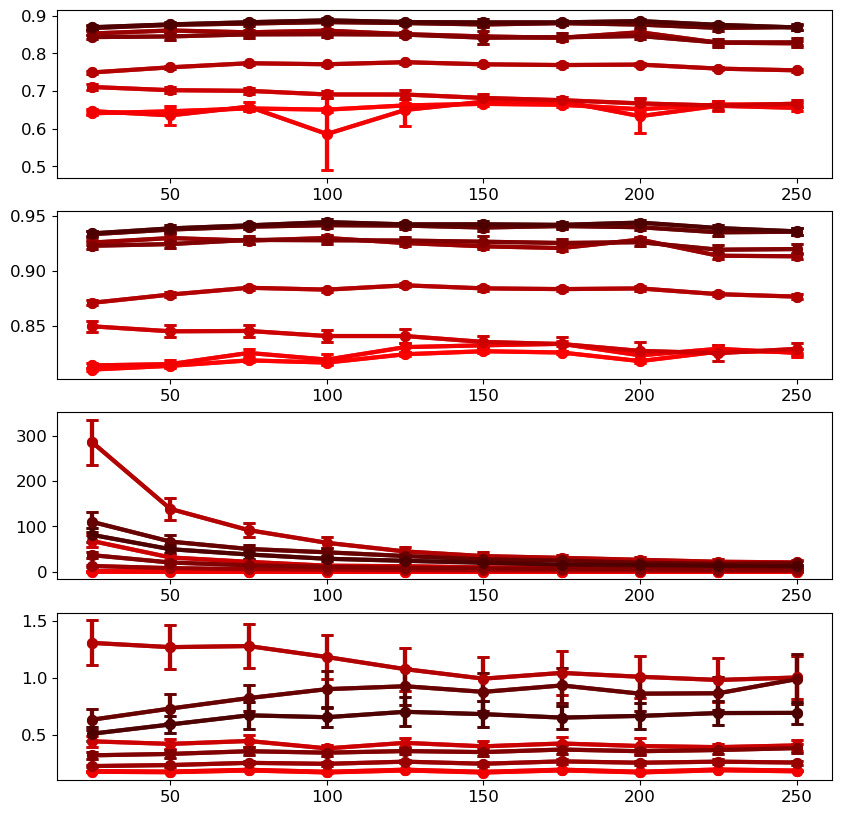

In [3]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(4,1,figsize=(10,10))

DF = df.loc[(df['output']=='position')]
behs = ['R2_mn','rho_mn','train_time','inference_time']

for i,beh in enumerate(behs):
    dff = DF[['model','output_binWidth',beh,'outer_fold']]
    obw = dff['output_binWidth'].unique()

    df_mn = dff.groupby(['output_binWidth','model'])[beh].mean().reset_index(name="mR2")
    df_sd = dff.groupby(['output_binWidth','model'])[beh].std().reset_index(name="sR2")
    
    for m in DF['model'].unique():
        mod_mn = df_mn.loc[df_mn['model']==m]['mR2'].values
        mod_sd = (df_sd.loc[df_sd['model']==m]['sR2'].values)*np.sqrt(1./10+1./(10-1))

        ax[i].errorbar(obw, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=reds[m], zorder=2)
        ax[i].errorbar(obw, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=reds[m], zorder=3)

#ax.set_xticks(np.arange(0,41,4))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
#ax.set_ylim(0.01,0.678)

#fig.savefig(fig_folder+'/r2_numNeurons-onesess.png', dpi=600, bbox_inches='tight') 

/var/folders/gf/jngvvwrj1p722fqyx4vypp540000gn/T/ipykernel_20297/1996013823.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['robustness_differential'] = (DF['R2tr_mn'] - DF['R2_mn']) / (DF['R2tr_mn'] + DF['R2_mn'])
/var/folders/gf/jngvvwrj1p722fqyx4vypp540000gn/T/ipykernel_20297/1996013823.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['robustness_differential'] = (DF['R2tr_mn'] - DF['R2_mn']) / (DF['R2tr_mn'] + DF['R2_mn'])
/var/folders/gf/jngvvwrj1p722fqyx4vypp540000gn/T/ipykernel_20297/1

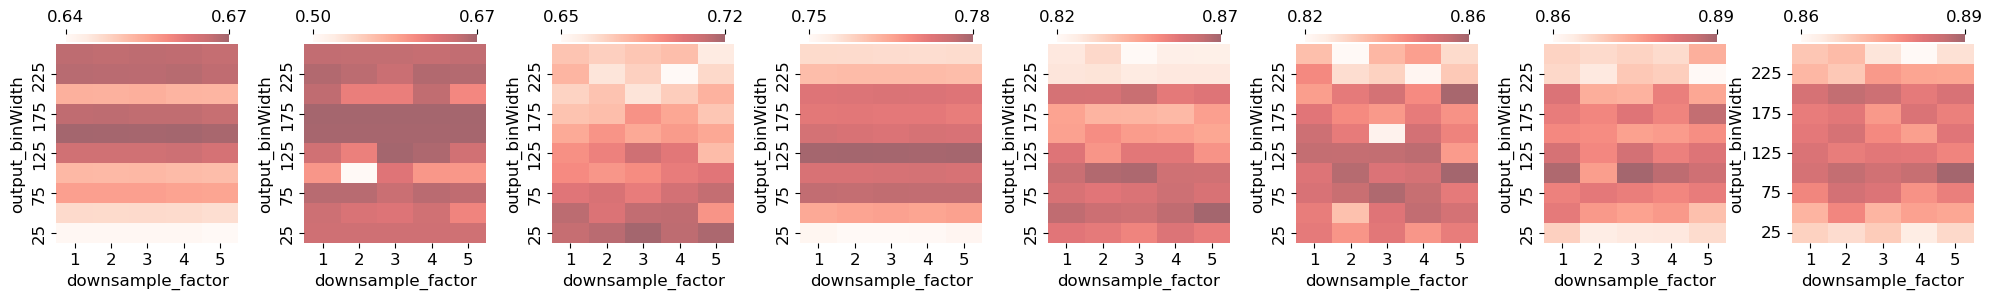

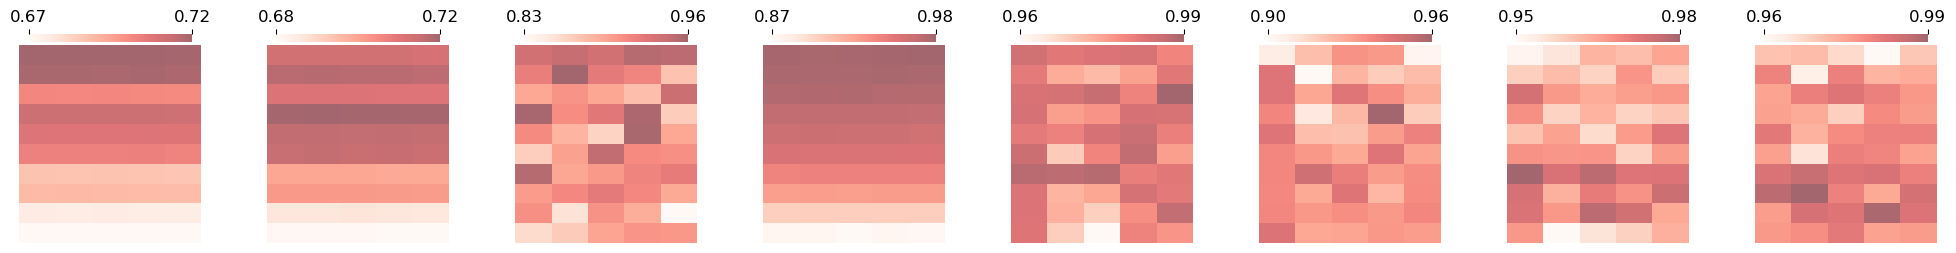

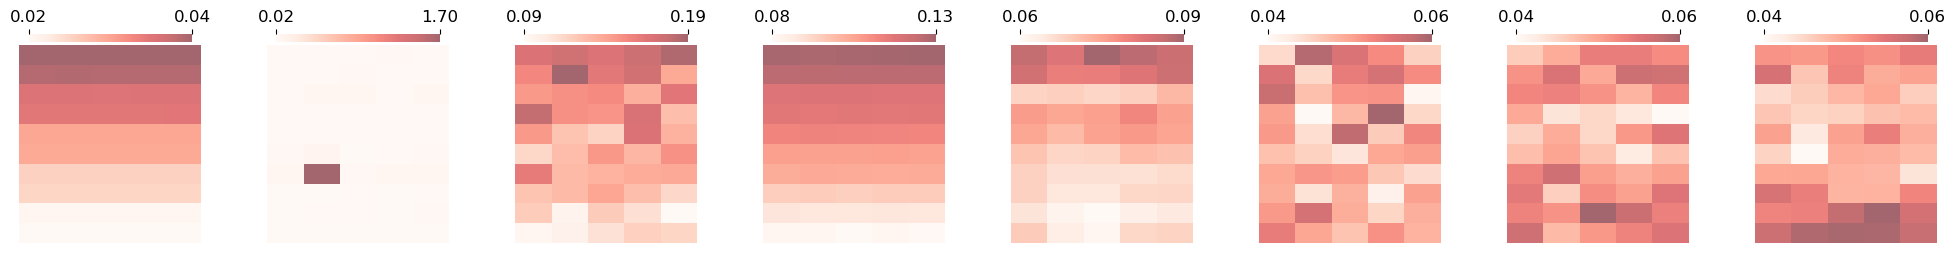

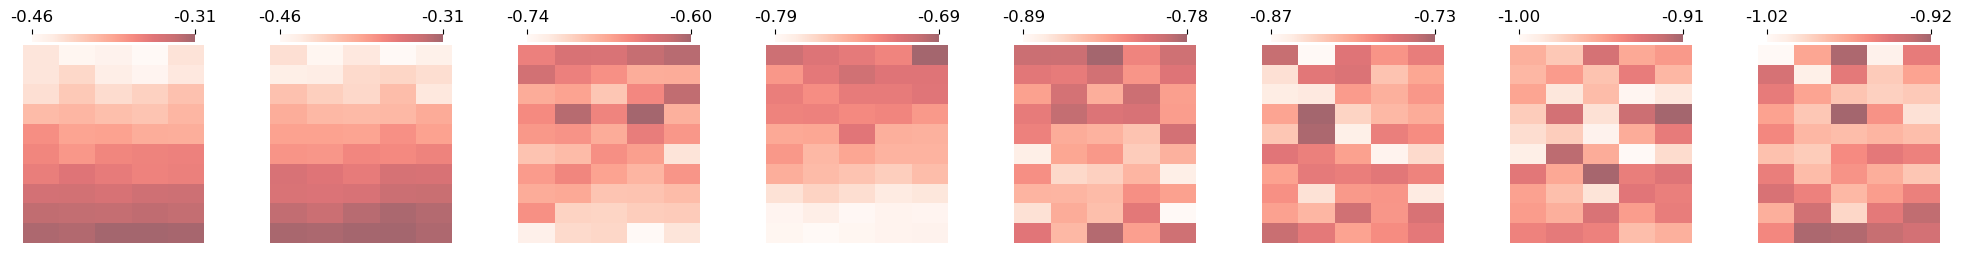

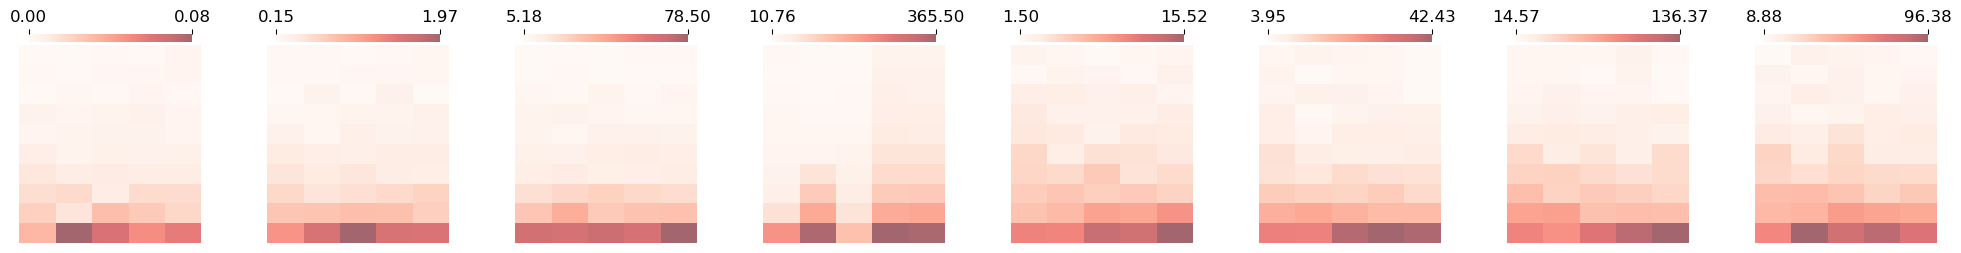

In [7]:
import matplotlib.ticker as ticker

################# R2 ###################
fig, ax = plt.subplots(1,8, figsize=(20,3))
fig.tight_layout(pad=1)

for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position') & (df['model']==m)]
    dff = DF[['R2_mn','output_binWidth','downsample_factor']]

    df_m = dff.groupby(['output_binWidth','downsample_factor'])["R2_mn"].mean().reset_index(name="R2")
    result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='R2')
    
    a = sns.heatmap(ax=ax[i],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=1,yticklabels=2, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
    a.invert_yaxis()
    plt.yticks(rotation=0) 
    #a.set(xlabel=None)
    #a.set(ylabel=None)
    
############### R2_train ##################
fig, ax = plt.subplots(1,8, figsize=(20,3))
fig.tight_layout(pad=1)

for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position') & (df['model']==m)]
    dff = DF[['R2tr_mn','output_binWidth','downsample_factor']]

    df_m = dff.groupby(['output_binWidth','downsample_factor'])["R2tr_mn"].mean().reset_index(name="rho")
    result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')
    
    a = sns.heatmap(ax=ax[i],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
    a.invert_yaxis()
    plt.yticks(rotation=0) 
    a.set(xlabel=None)
    a.set(ylabel=None)
    
############### R2_train ##################
fig, ax = plt.subplots(1,8, figsize=(20,3))
fig.tight_layout(pad=1)

for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position') & (df['model']==m)]
    DF['robustness_differential'] = (DF['R2tr_mn'] - DF['R2_mn']) / (DF['R2tr_mn'] + DF['R2_mn'])
    dff = DF[['robustness_differential','output_binWidth','downsample_factor']]

    df_m = dff.groupby(['output_binWidth','downsample_factor'])["robustness_differential"].mean().reset_index(name="rho")
    result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')
    
    a = sns.heatmap(ax=ax[i],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
    a.invert_yaxis()
    plt.yticks(rotation=0) 
    a.set(xlabel=None)
    a.set(ylabel=None)

    
############### R2_shuf ##################
fig, ax = plt.subplots(1,8, figsize=(20,3))
fig.tight_layout(pad=1)

for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position') & (df['model']==m)]
    dff = DF[['R2sh_mn','output_binWidth','downsample_factor']]

    df_m = dff.groupby(['output_binWidth','downsample_factor'])["R2sh_mn"].mean().reset_index(name="rho")
    result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')
    
    a = sns.heatmap(ax=ax[i],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
    a.invert_yaxis()
    plt.yticks(rotation=0) 
    a.set(xlabel=None)
    a.set(ylabel=None)
    
############### train_time ##################
fig, ax = plt.subplots(1,8, figsize=(20,3))
fig.tight_layout(pad=1)

for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position') & (df['model']==m)]
    dff = DF[['train_time','output_binWidth','downsample_factor']]

    df_m = dff.groupby(['output_binWidth','downsample_factor'])["train_time"].mean().reset_index(name="rho")
    result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')
    
    a = sns.heatmap(ax=ax[i],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
    a.invert_yaxis()
    plt.yticks(rotation=0) 
    a.set(xlabel=None)
    a.set(ylabel=None)

/var/folders/gf/jngvvwrj1p722fqyx4vypp540000gn/T/ipykernel_20297/1570205729.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['R2_mn_normalized'] = DF.groupby('model')['R2_mn'].transform(normalize_column)
/var/folders/gf/jngvvwrj1p722fqyx4vypp540000gn/T/ipykernel_20297/1570205729.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['R2_mn_normalized'] = DF.groupby('model')['rho_mn'].transform(normalize_column)
/var/folders/gf/jngvvwrj1p722fqyx4vypp540000gn/T/ipykernel_20297/1570205729.py:43: Settin

[Text(701.2439613526572, 0.5, '')]

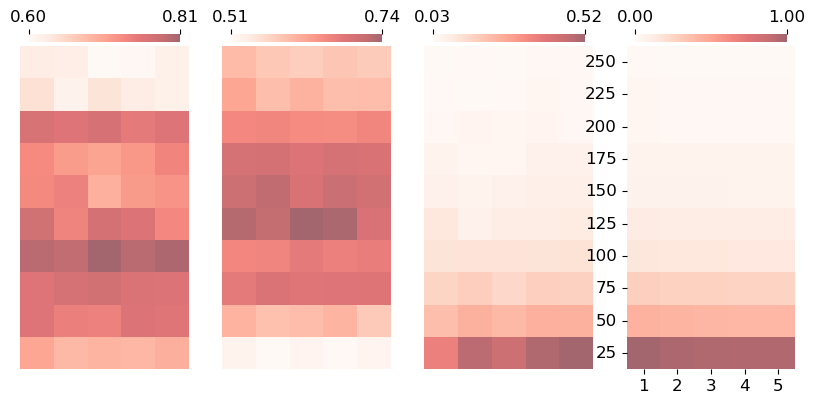

In [5]:
fig, ax = plt.subplots(1,4, figsize=(10,5))

# Define a function to normalize a column to the range [0, 1]
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)
    #return (column)/(max_val)
    #return zscore(column)

# R2
DF = df.loc[(df['output']=='position') & (df['model'] > 4)]
DF['R2_mn_normalized'] = DF.groupby('model')['R2_mn'].transform(normalize_column)

dff = DF[['R2_mn_normalized','output_binWidth','downsample_factor']]

df_m = dff.groupby(['output_binWidth','downsample_factor'])["R2_mn_normalized"].mean().reset_index(name="rho")
result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')

a = sns.heatmap(ax=ax[0],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
a.invert_yaxis()
plt.yticks(rotation=0) 
a.set(xlabel=None)
a.set(ylabel=None)

# RHO
DF = df.loc[(df['output']=='position')]
DF['R2_mn_normalized'] = DF.groupby('model')['rho_mn'].transform(normalize_column)

dff = DF[['R2_mn_normalized','output_binWidth','downsample_factor']]

df_m = dff.groupby(['output_binWidth','downsample_factor'])["R2_mn_normalized"].mean().reset_index(name="rho")
result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')

a = sns.heatmap(ax=ax[1],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
a.invert_yaxis()
plt.yticks(rotation=0) 
a.set(xlabel=None)
a.set(ylabel=None)

# Group by 'model' and normalize 'R2_mn' within each group
DF = df.loc[(df['output']=='position')]
DF['train_time_normalized'] = DF.groupby('model')['train_time'].transform(normalize_column)

dff = DF[['train_time_normalized','output_binWidth','downsample_factor']]

df_m = dff.groupby(['output_binWidth','downsample_factor'])["train_time_normalized"].mean().reset_index(name="rho")
result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')

a = sns.heatmap(ax=ax[2],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=0,yticklabels=0, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
a.invert_yaxis()
plt.yticks(rotation=0) 
a.set(xlabel=None)
a.set(ylabel=None)

# Group by 'model' and normalize 'R2_mn' within each group
DF = df.loc[(df['output']=='position')]
DF['train_time_normalized'] = DF.groupby('model')['preProcess_time'].transform(normalize_column)

dff = DF[['train_time_normalized','output_binWidth','downsample_factor']]

df_m = dff.groupby(['output_binWidth','downsample_factor'])["train_time_normalized"].mean().reset_index(name="rho")
result = df_m.pivot(index='output_binWidth', columns='downsample_factor', values='rho')

a = sns.heatmap(ax=ax[3],data=result,cmap="Reds", mask=result.isnull(), alpha=0.6, xticklabels=1,yticklabels=1, cbar_kws={'location':'top','ticks':[np.min(result),np.max(result)],'orientation':'horizontal','pad':0.01,"shrink":0.9,'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
a.invert_yaxis()
plt.yticks(rotation=0) 
a.set(xlabel=None)
a.set(ylabel=None)

In [ ]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,1,figsize=(5,4))

beh = 'R2_mn'

DF = df.loc[df['output_binWidth']==25]
DF = DF[['model','downsample_factor',beh,'outer_fold']]
obw = DF['downsample_factor'].unique()

df_mn = DF.groupby(['downsample_factor','model'])[beh].mean().reset_index(name="mR2")
df_sd = DF.groupby(['downsample_factor','model'])[beh].std().reset_index(name="sR2")

for m in DF['model'].unique():
    mod_mn = df_mn.loc[df_mn['model']==m]['mR2'].values
    print(len(mod_mn))
    mod_sd = (df_sd.loc[df_sd['model']==m]['sR2'].values)*np.sqrt(1./10+1./(10-1))

    ax.errorbar(obw, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=reds[m], zorder=2)
    ax.errorbar(obw, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=reds[m], zorder=3)

#ax.set_xticks(np.arange(0,41,4))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
#ax.set_ylim(0.01,0.678)

#fig.savefig(fig_folder+'/r2_numNeurons-onesess.png', dpi=600, bbox_inches='tight') 